**Models**:
- Logistic Regression (LR)
- Random Forest (RF)
- Neural Network (NN)

# Table of Contents

>[Table of Contents](#scrollTo=1vIrrlI5qYYy)

>[Load Packages](#scrollTo=7kYT-Av0M30Y)

>[Load Datasets and Basic Data Cleaning](#scrollTo=W8j2Yk93M30a)

>>[BC & RF: features dataset](#scrollTo=ogBM3dkMM30a)

>>[NN: sites_data.csv](#scrollTo=XsGpGZJoM30b)

>>[All: Pollution Data](#scrollTo=iAjdKpWAM30b)

>[Data Manipulation and Further Data Cleaning](#scrollTo=7jfpVEdhM30b)

>>>[BC & RF: Replace NaNs with mean](#scrollTo=2tNYFCXyM30b)

>>>[BC & RF: Replace NaNs with -10](#scrollTo=w2nMfJ_MM30c)

>[Train-Test Split](#scrollTo=k5Rh25eDM30d)

>>[5-fold CV on Training Data](#scrollTo=NVfVZtslVDgN)

>[Train & Test Models](#scrollTo=LqVCHBwqM30d)

>>[Baseline](#scrollTo=WCq5OTnjM30d)

>>[BC](#scrollTo=fCm5MtmEM30d)

>>>[df_merged_mean](#scrollTo=sk2ahJhvM30d)

>>>>[ROC](#scrollTo=AUtGhFBxM30f)

>>>[df_merged_neg](#scrollTo=LbH3oq34M30f)

>>[RF](#scrollTo=tX_m83LwM30g)

>>>[df_merged_mean](#scrollTo=WwjWWDddM30g)

>>>>[Importance of Feature Aggregation](#scrollTo=HSd3THghM30h)

>>>>[PCA](#scrollTo=ce8UQqnCM30h)

>>>[df_merged_neg](#scrollTo=yNtOjtXHM30h)

>>>>[Importance of Feature Aggregation](#scrollTo=d85180_iM30i)

>>>>[PCA](#scrollTo=3iz1OD5WM30i)

>>[NN](#scrollTo=HqmPxsTQM30j)

>>>[Helper Functions](#scrollTo=kweB7fnOM30j)

>>>[Training Models](#scrollTo=42b7DOTtM30k)

>>>>[Training From Scratch](#scrollTo=orGBi9j_QSm6)

>>>>>[With Cross Validation (Takes up too much RAM)](#scrollTo=CQ2WRerRdX5E)

>>>>>[Save Model](#scrollTo=VY6Q610dder6)

>>>>[Training From Existing Model](#scrollTo=7_MflnfHQXCz)

>>>>>[Load Model From File](#scrollTo=qbDjSSIaoPmH)

>>>>>[Training](#scrollTo=um8esTkeoRAe)

>[Final Results](#scrollTo=KCRcg5wRM30k)

>[Window Size Comparison](#scrollTo=MhySSdKwM30l)

>>[BC](#scrollTo=_xgmshK1M30l)

>>[RF](#scrollTo=kiYFhCJiM30l)

>>[NN](#scrollTo=Y54BwAv-M30l)

>[Accuracy Comparison](#scrollTo=yw0R9N0gM30m)

>>[NN](#scrollTo=OZhXFnbPM30m)



# &nbsp; Load Packages

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import backend as K
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from datetime import datetime
from keras.optimizers import Adam
import itertools
from IPython.display import clear_output
import pickle
from collections import defaultdict
import random
import gc
import csv
from sklearn.metrics import precision_recall_curve

In [ ]:
# tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

# Load Cleaned Datasets

## NN: sites_data.csv

In [4]:
%%time
# L3 data, Sentinel 3, 1km x 1km, 6 features
# sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_15x15_6_features_na_mean_zero_no_norm.pkl")
sites_data = pd.read_pickle("nn_15x15_6_features_na_mean_zero_no_norm.pkl")

CPU times: user 2.59 s, sys: 1.53 s, total: 4.12 s
Wall time: 5.44 s


In [ ]:
# duplicates = sites_data.duplicated(subset=['time','site'], keep=False)
# sites_data[duplicates]
# sites_data_no_duplicates = sites_data.drop_duplicates(subset=['time', 'site'])
# sites_data_no_duplicates

### Filtering Data so only run NN on part of the data

In [ ]:
for feature in ['ZSD', 'CHL', 'SPM', 'KD490', 'BBP', 'CDM']:
  sites_data[f'feature_sum_{feature}'] = [sum(sum(i)) for i in sites_data[f'{feature}']]

sites_data

In [ ]:
sites_data['feature_sum_boolean'] = sites_data[['feature_sum_ZSD', 'feature_sum_CHL','feature_sum_SPM','feature_sum_KD490', 'feature_sum_BBP', 'feature_sum_CDM']].ne(0).all(axis=1)
sites_data

In [ ]:
sites_data['feature_sum_boolean'].value_counts()

In [ ]:
sites_data_ = sites_data[sites_data['feature_sum_boolean'] == True]

In [ ]:
sites_data = sites_data_

In [ ]:
sites_data

In [ ]:
sites_data = sites_data[['time', 'site', 'SPM', 'ZSD', 'BBP', 'CDM', 'KD490', 'CHL', 'riskLevelLabel']]

In [ ]:
len(sites_data["feature_sum_"][0])

In [ ]:
sites_data['feature_sum'] = [sum(sum(i)) for i in (sites_data['ZSD'] + sites_data['CHL'] + sites_data['SPM'] + sites_data['KD490'] + sites_data['BBP'] + sites_data['CDM'])]

In [ ]:
sites_data["feature_sum"]

In [ ]:
sites_data.plot(kind='hist')

In [ ]:
sites_data_ = sites_data[sites_data['feature_sum'] > 0]
sites_data_.drop('feature_sum', axis=1, inplace=True)
sites_data_

In [ ]:
sites_data = sites_data_

In [ ]:
# # L4 data, Sentinel 2, 100m x 100m, 3 features (TUR, SPM, CHL)

# sites_data2 = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51.pkl")
# sites_data2

In [ ]:
# # L3 data, Sentinel 3, 300m x 300m, 51x51, 1 feature (CHL)

# sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51_chl.pkl")
# sites_data

In [ ]:
# # L3 data, Sentinel 3, 1km x 1km, 15x15, 6 feature (CHL), fillna=0

# sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51_6_features.pkl")
# sites_data

In [ ]:
# # L3 data, Sentinel 3, 1km x 1km, 15x15, 6 feature (CHL), fillna = -10

# sites_data = pd.read_pickle("/content/drive/My Drive/CapstoneProject/Datasets/nn_51x51_neg10_6_features.pkl")
# sites_data

In [ ]:
# sites_data.isnull().sum()

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
# import psutil
# split_bar = '='*20
# memory_info = psutil.virtual_memory()._asdict()
# print(f"{split_bar} Memory Usage {split_bar}")
# for k,v in memory_info.items():
#   print(k, v)
# print(f"{split_bar} CPU Usage {split_bar}")
# print(f"CPU percent: {psutil.cpu_percent()}%")

# Train-Test-Validation Split

In [5]:
# time_site_pairs_train = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/train_labels_mean_zero.csv")[['time', 'site']]
# time_site_pairs_valid = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/validation_labels_mean_zero.csv")[['time', 'site']]
# time_site_pairs_test = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/test_labels_mean_zero.csv")[['time', 'site']]

time_site_pairs_train = pd.read_csv("~data/train_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_valid = pd.read_csv("~data/validation_labels_mean_zero.csv")[['time', 'site']]
time_site_pairs_test = pd.read_csv("~data/test_labels_mean_zero.csv")[['time', 'site']]

In [ ]:
# time_site_pairs_train2 = time_site_pairs2[~time_site_pairs2.isin(time_site_pairs_test2)].dropna()
# time_site_pairs_train2 = time_site_pairs_train2.sample(frac=1, random_state=42)

In [ ]:
# time_site_pairs = sites_data[['time', 'site']]

# # shuffle df
# time_site_pairs = time_site_pairs.sample(frac=1, random_state=42)

# # rows of split
# total_rows = time_site_pairs.shape[0]
# train_split = int(0.6 * total_rows)
# validation_split = int(0.2 * total_rows)

# # split
# train_df = time_site_pairs[:train_split]
# validation_df = time_site_pairs[train_split:(train_split + validation_split)]
# test_df = time_site_pairs[(train_split + validation_split):]

In [ ]:
# # sanity checks

# print(f"Rows of entire dataset: {time_site_pairs.shape[0]}")
# print(f"Rows of train: {train_df.shape[0]}")
# print(f"Rows of validation: {validation_df.shape[0]}")
# print(f"Rows of test: {test_df.shape[0]}")

# train = sites_data.merge(train_df, on=['time', 'site'], how='inner')
# validation = sites_data.merge(validation_df, on=['time', 'site'], how='inner')
# test = sites_data.merge(test_df, on=['time', 'site'], how='inner')

# print(f"Positive samples in train: {sum(train['riskLevelLabel'])}. % of Positive samples in train: {sum(train['riskLevelLabel'])/len(train_df)*100}%")
# print(f"Positive samples in validation: {sum(validation['riskLevelLabel'])}. % of Positive samples in validation: {sum(validation['riskLevelLabel'])/len(validation_df)*100}%")
# print(f"Positive samples in test: {sum(test['riskLevelLabel'])}. % of Positive samples in test: {sum(test['riskLevelLabel'])/len(test_df)*100}%")

In [ ]:
# # export to csv

# train_df.to_csv("/content/drive/My Drive/CapstoneProject/Datasets/train_labels_mean_zero.csv")
# validation_df.to_csv("/content/drive/My Drive/CapstoneProject/Datasets/validation_labels_mean_zero.csv")
# test_df.to_csv("/content/drive/My Drive/CapstoneProject/Datasets/test_labels_mean_zero.csv")

In [ ]:
# time_site_pairs = sites_data[['time', 'site']]

# # 80/20 split
# time_site_pairs_test = time_site_pairs.sample(frac=.2, random_state=42)
# time_site_pairs_test

In [ ]:
# time_site_pairs_train = time_site_pairs[~time_site_pairs.isin(time_site_pairs_test)].dropna()
# time_site_pairs_train = time_site_pairs_train.sample(frac=1, random_state=42)
# time_site_pairs_train

In [ ]:
# time_site_pairs_test.to_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_test_6_features.csv")
# time_site_pairs_train.to_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_train_6_features.csv")

In [ ]:
# time_site_pairs_test = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_test_6_features.csv")[['time', 'site']]
# time_site_pairs_train = pd.read_csv("/content/drive/My Drive/CapstoneProject/Datasets/time_site_pairs_train_6_features.csv")[['time', 'site']]
# #time_site_pairs_train

In [ ]:
# time_site_pairs_train.shape[0] + time_site_pairs_test.shape[0]

## 5-fold CV on Training Data

In [7]:
# Randomise order of training pairs
time_site_pairs_train_new = time_site_pairs_train.sample(frac = 1)

train_val_dict = {}

# Get CV Train and Test time-site pairs
for i in range(5):
  split_index = round(len(time_site_pairs_train_new)/5)
  train_val_dict[f'val_{i+1}'] = time_site_pairs_train_new[i*split_index: (i+1)*split_index]
  train_val_dict[f'train_{i+1}'] = time_site_pairs_train_new.drop(time_site_pairs_train_new.index[i*split_index: (i+1)*split_index])

# Train & Test Models
- Train on training time-site pairs
- Test on testing time-site pairs

## NN

### Helper Functions

#### Reshaping Data as Tensors

In [77]:
def get_train_test_val_nn(input_data, train_labels, test_labels, dim = 15, oversampling = False, augment=True, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
    Gets train, test and validation datasets for a neural network model.

    input:
        - input_data (pd.DataFrame):
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'

        - train_labels / test_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train/test data

        - oversampling (boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data

    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''


    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])

    ################
    # Changing window size
    ################
    w = int((dim-1)/2)

    def get_windowed_data(row):
        indices = np.array(range(1,226)).reshape(15,15)[7-w:8+w, 7-w:8+w].flatten()
        indices = [i-1 for i in indices]
        values = row.flatten()[[indices]].reshape(dim,dim)
        return values

    if dim != 15:
        for feature in ['ZSD','CHL','SPM','KD490','BBP','CDM']:
            train[f'{feature}'] = train[f'{feature}'].apply(get_windowed_data)
            test[f'{feature}'] = test[f'{feature}'].apply(get_windowed_data)

    print(train['SPM'][3])

    ################
    # Getting X & y, train & val
    ################

    # Getting X & y
    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)

    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = train['riskLevelLabel']
    y_test = test['riskLevelLabel']

    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]

    ################
    # Oversampling (on training data)
    ################

    if oversampling:
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives

        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    ################
    # Reshaping into tensors
    ################

    X_dfs = []
    for X_df in [X_train, X_test, X_val]:

        # Reshape and Convert to Tensor
        if X_df.shape[1] == 1:
            X_df = np.array([i for i in X_df[features_column_names[0]]])
            X_df = tf.convert_to_tensor(X_df)
            X_df = tf.expand_dims(X_df, axis=3, name=None)
        else:
            X_df = np.stack([np.stack(X_df[col].values) for col in X_df.columns], axis=1)
            X_df = np.transpose(X_df, (0, 2, 3, 1))
            X_df = tf.convert_to_tensor(X_df)

        # Padding
#         X_df = tf.pad(X_df, [[0, 0], [16-w,15-w], [16-w,15-w], [0,0]])

        # Append
        X_dfs.append(X_df)

    X_train, X_test, X_val = X_dfs

    ################
    # Data Augmentation on minority class
    ################

    if augment:
      # separating positive class data points
      positive_indices = [[i] for i in np.where(y_train == 1)[0]]
      X_train_pos = tf.gather_nd(X_train, indices=positive_indices)

      # augment
      augmented_X = []

      for j in np.arange(len(X_train_pos)):
          original = X_train_pos[j]
          hor_flip = tf.image.flip_left_right(original)
          ver_flip = tf.image.flip_up_down(original)

          augmented_X.append(hor_flip)
          augmented_X.append(ver_flip)

          for i in [1,2,3]:
              augmented_X.append(tf.image.rot90(original, k=i))
              augmented_X.append(tf.image.rot90(hor_flip, k=i))
              augmented_X.append(tf.image.rot90(ver_flip, k=i))

      # add augmented data to X_train
      augmented_X_tensor = tf.convert_to_tensor(np.array(augmented_X))
      X_train = tf.concat([X_train, augmented_X_tensor], 0)

      # expanding y_train to match
      y_train = pd.concat([y_train, pd.Series([1]*len(augmented_X))]).reset_index(drop=True)

      # shuffle
      indices = np.arange(X_train.shape[0])
      np.random.shuffle(indices)
      idx = [[i] for i in indices]
      X_train = tf.gather_nd(X_train, indices=idx)
      y_train = y_train[indices]


    ################
    # Data type for y values
    ################

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    y_val = y_val.astype('float32')

    return {'X_train': X_train,
            'X_test': X_test,
            'X_val': X_val,
            'y_train': y_train,
            'y_test': y_test,
            'y_val': y_val}

In [78]:
# Custom F1 Score

def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# custom loss function
def wbce_custom(weight1_=30):

    def wbce(y_true, y_pred, weight1=weight1_, weight0=1.):

        tf.cast(y_true, tf.float32)
        tf.cast(y_pred, tf.float32)
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )

        return K.mean(logloss, axis=-1)

    return wbce

#### Fitting NN Model (Model Specifications)

In [80]:
def fit_nn(xy_data, model_type="convolution", existing_model=None, metrics=['acc','AUC','Precision','Recall', f1],
           loss=wbce_custom, optimizer='adam',
          batch_size=64, epochs=20, dropout=0.25, patience=5, verbose=1):
    '''
    xy_data: dictionary with X_train, X_test, X_val, y_train, y_test, y_val in this order (dict)
    model_type: "baseline"/"convolution" (string)
    loss: "binary_crossentropy" (string)
    metrics: list of metrics to track. available metrics are: (list of string/function)
        - "acc"
        - "AUC"
        - "Precision"
        - "Recall"
        - f1
    '''

    # unpacking data
    X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

    # weight initializer
    # initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

    output_bias = tf.keras.initializers.Constant(np.log([sum(y_train)/(len(y_train)-sum(y_train))]))

    # building model
    if existing_model==None:
      model = models.Sequential()

      if model_type == "baseline":
          model.add(layers.AveragePooling2D(pool_size=4, strides=4, input_shape=X_train.shape[1:]))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dense(1, activation="sigmoid"))

      elif model_type == "convolution":
        model.add(layers.Conv2D(filters=6, kernel_size=5, input_shape=(15,15,6), kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))

        model.add(layers.Conv2D(filters=16, kernel_size=3, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
        model.add(BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=2, strides=2))

        model.add(layers.Flatten())
        model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(84, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
        model.add(layers.Dropout(dropout)),
        model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))


      elif model_type == "convolution_v3":
          model.add(layers.Conv2D(filters=6, kernel_size=5, padding='same', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
          model.add(BatchNormalization())
          model.add(layers.Activation('relu'))
          model.add(layers.MaxPooling2D(pool_size=2, strides=2))

          model.add(layers.Conv2D(filters=16, kernel_size=5, kernel_regularizer=l2(0.0005), bias_regularizer=l2(0.0005)))
          model.add(BatchNormalization())
          model.add(layers.Activation('relu'))
          model.add(layers.MaxPooling2D(pool_size=2, strides=2))

          model.add(layers.Flatten())
          model.add(layers.Dense(120, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(84, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
          model.add(layers.Dropout(dropout)),
          model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
          # model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

      elif model_type == "convolution_v2":
          model.add(layers.Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(5, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(1, activation='sigmoid'))

      elif model_type == "convolution_v1":
          model.add(layers.Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=X_train.shape[1:]))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.AveragePooling2D(pool_size=4, strides=4))
          model.add(layers.Flatten())
          model.add(layers.Dense(10, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(5, activation='relu'))
          model.add(layers.Dropout(dropout))
          model.add(layers.Dense(1, activation='sigmoid'))

      else:
          print('Model Type Undefined')

      model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
      print(model.optimizer.get_config())
      print(model.get_config())

    else:
      model = existing_model
      print(model.optimizer.get_config())
      print(model.get_config())

    # callback for early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=patience)

    # callback for model checkpoint
    # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/CapstoneProject/Models/Checkpoints',
    #                                                                save_weights_only=True,
    #                                                                monitor='val_f1',
    #                                                                mode='max',
    #                                                                save_best_only=True)

    # Fit Model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[GarbageCollectorCallback(), es], verbose=verbose)

    # Evaluate Model
    result = model.evaluate(X_test, y_test, callbacks=[GarbageCollectorCallback()])

    for i in [X_train, X_test, X_val, y_train, y_test, y_val]:
      del i
    gc.collect()

    return model, history, result

In [9]:
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [10]:
def run_nn(num_feature=3, model_type="convolution", batch_size=64, epochs=100,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0001),
           existing_model = None, metrics=["f1"], dropout=0.25, patience=5, verbose=1,
           train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_test):

    # start time
    print(datetime.now())

    # Getting Input Data
    if num_feature == 1:
        input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 3:
        input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 6:
        input_data_ = sites_data[['ZSD', 'CHL', 'SPM', 'KD490', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

    elif num_feature == 6.1:
        input_data_ = sites_data[['SPM', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

    else:
      print('Number of features Error')

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                          train_pairs,
                          test_pairs)

    # Get history and result
    model_, history, result = fit_nn(xy_data, model_type, existing_model=existing_model,
                                     batch_size=batch_size, epochs=epochs, loss=loss,
                                     optimizer=optimizer, dropout=dropout, patience=patience, verbose=verbose)

    # Plot
    if (existing_model == None) & (verbose != 2) & (verbose != 0):
      plot_train_val_loss(history.history, metrics=metrics)

    del xy_data
    gc.collect()

    # end time
    print(datetime.now())

    return model_, history, result

#### Plotting Functions

In [143]:
def confusion_matrix_plot(y_test, y_pred):

    # if num_feature == 1:
    #     input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

    # elif num_feature == 3:
    #     input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

    # # Getting xy_data
    # xy_data = get_train_test_val_nn(input_data_,
    #                        time_site_pairs_train,
    #                        time_site_pairs_test,
    #                        oversampling = oversampling__)

    # X_test = xy_data['X_test']
    # y_test = xy_data['y_test']

    # preds = model.predict(X_test)
    # y_pred = np.where(preds>0.5,1,0)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # fig, ax = plt.subplots(figsize=(4,4))
    # ax.imshow(cm)
    # ax.grid(False)
    # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    # ax.set_ylim(1.5, -0.5)
    # for i in range(2):
    #     for j in range(2):
    #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    # plt.show()

In [12]:
def plot_train_val_loss(his, metrics=['f1', 'precision', 'recall']):
    '''
    input:
        - history (dictionary)
        - metrics (list of strings)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(len(metrics)+1, 1, figsize=(5,5+len(metrics)*2))
    fig.tight_layout(pad=5)
    axs[0].plot(his['loss'])
    axs[0].plot(his['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])

    for j, metric in enumerate(metrics):
        axs[j+1].plot(his[f'{metric}'])
        axs[j+1].plot(his[f'val_{metric}'])
        axs[j+1].title.set_text(f'Training {metric} vs Validation {metric}')
        axs[j+1].legend(['Training', 'Validation'])
        axs[j+1].set_xlabel("Epochs")
        axs[j+1].set_ylabel(f"{metric}")

In [13]:
def get_combined_history(history_list):
  '''
  history_list (list): list of dictionaries containing histories, in order
  '''
  dd = defaultdict(list)
  all_history = {}

  for d in [old_history, history.history]:
    for key, value in d.items():
      dd[key].append(value)

  for key, value in dd.items():
      all_history[key] = [item for sublist in value for item in sublist]

  return all_history

#### Save & Load Model

In [14]:
def save_model(model, history, result, model_notes, model_specs = '51x51'):
  # model name
  now = datetime.now()
  day, month, time = now.day, now.month, now.strftime("%H%M")
  model_name = f"nn_{model_specs}_{month}_{day}_{time}"

  # save model
  model.save(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras')

  # save history
  with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

  model_notes_row = [model_name, model_notes, result]

  with open('/content/drive/My Drive/CapstoneProject/Models/model_notes.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    f.write("\n")
    writer.writerow(model_notes_row)
    f.close()

  print(f"Model Name: {model_name}")

In [15]:
def load_model(model_name, loss_weight=30):
  # Load Model
  loss = wbce_custom(loss_weight)
  metric = f1
  old_model = tf.keras.models.load_model(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

  # Load History
  with open(f'/content/drive/My Drive/CapstoneProject/Models/{model_name}_hist', "rb") as file_pi:
      old_history = pickle.load(file_pi)

  notes = pd.read_csv(("/content/drive/My Drive/CapstoneProject/Models/model_notes.csv"))
  print(notes[notes['Model Name'] == model_name]['Notes'].iloc[0])

  return old_model, old_history

# Training Models

#### Training From Scratch

##### Without Cross Validation

2023-08-19 02:24:00.026959
{'name': 'Adam', 'learning_rate': 1e-05, 'decay': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential_22', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 15, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_44_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_44', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 15, 15, 6), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'bias_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'activity_regula

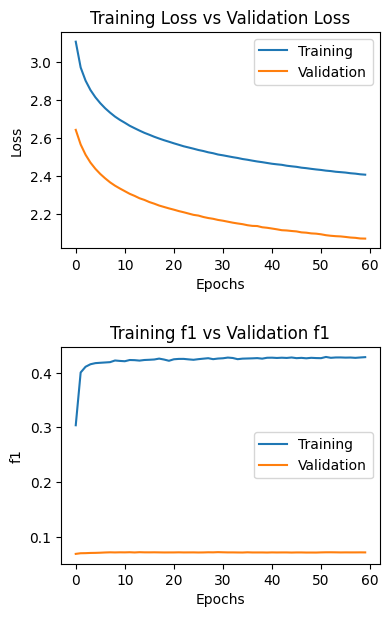

In [40]:
%%time
# run model
model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=64, epochs=500,
           loss=wbce_custom(3.5), optimizer=Adam(learning_rate=0.00001, decay=0.001), dropout=0.1, patience=30,
           existing_model = None, metrics=['f1'], train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

##### With Cross Validation (Takes up too much RAM)

In [ ]:
# %%time

# model_types = ["convolution"]
# num_features = [3]
# i = 0

# for model_type, num_feature in itertools.product(model_types, num_features):

#     for j in range(5):
#       # Getting Input Data
#       if num_feature == 1:
#           input_data_ = sites_data[['CHL', 'riskLevelLabel', 'site', 'time']]

#       elif num_feature == 3:
#           input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

#       # Getting xy_data
#       xy_data = get_train_test_val_nn(input_data_,
#                             train_test_dict[f'train_{j+1}'],
#                             train_test_dict[f'test_{j+1}'])

#       # Get history and result
#       model_, history, result = fit_nn(xy_data, model_type, batch_size=32, epochs=3, loss=wbce_custom(50), optimizer=Adam(learning_rate=0.0005))
#       model_list.append(model_)
#       histories.append(history)
#       results.append(result)

#       i += 1
#       clear_output(wait=True)

#       K.clear_session()
#       tf.compat.v1.reset_default_graph()
#       gc.collect()

#       print(f'Progress: {i}/{len(model_types)*len(num_features)*5}')
#       print(datetime.now())

##### Save Model

In [ ]:
model_notes = '''dataset: L3 1km x 1km 15x15, fillna = mean then 0, num_feature=6, model_type="convolution v3 (lenet)", batch_size=64, epochs=98,
           loss=wbce_custom(30), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay l2 regularisation. added batch norm. use kernel_size = 3 instead of 5.
           early stopping patience = 30. '''
save_model(model, history, result, model_notes, model_specs = '15x15')

Model Name: nn_15x15_7_23_2222


##### (Attempt to) Clear RAM

In [ ]:
# del model
# del history
# del result
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# gc.collect()

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

#### Training From Existing Model

##### Load Model From File

In [ ]:
old_model, old_history = load_model('nn_15x15_7_20_1323', loss_weight=40)

dataset: L3 1km x 1km 15x15, fillna = mean then 0, num_feature=6, model_type="convolution v3 (lenet)", batch_size=64, epochs=200,
           loss=wbce_custom(40), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay l2 regularisation. added batch norm. removed time and site pairs with >8000


##### Training

In [ ]:
%%time
# run model - change parameters as needed to match initial model!!!
model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=64, epochs=200,
           loss=wbce_custom(40), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = old_model, metrics=['f1'])

# Combine new history with old history
all_history = get_combined_history([old_history, history.history])

2023-07-20 13:41:36.949359
X_train shape: (6052, 15, 15, 6)
{'name': 'Adam', 'learning_rate': 5e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential_2', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 15, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_4_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 15, 15, 6), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'bias_regularizer': {'class_name': 'L2', 'config': {'l2': 0.000500000023

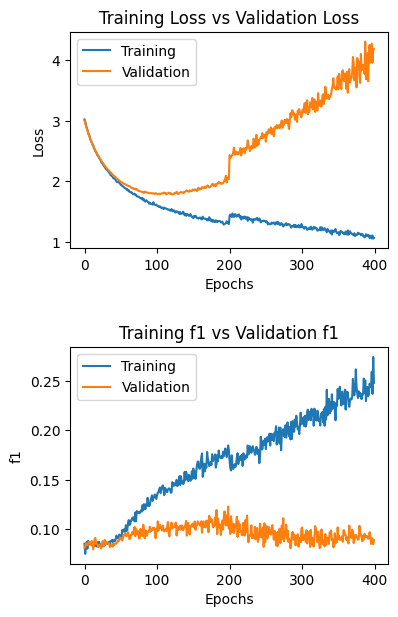

In [ ]:
plot_train_val_loss(all_history, metrics=['f1'])

In [ ]:
# Save Model

model_notes = '''dataset: L3 300mx300m CHL, 15x15, num_feature=6, model_type="convolution", batch_size=64, epochs=300,
           loss=wbce_custom(50), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay. added batch norm.'''
save_model(model, history, result, model_notes)

Model Name: nn_51x51_7_10_2317


In [ ]:
# input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

# # Getting X_test and y_test
# xy_data = get_train_test_val_nn(input_data_,
#                       time_site_pairs_train,
#                       time_site_pairs_test)

# X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

# result = model.evaluate(X_test, y_test)

#### Hyperparameter Tuning

##### Hyperopt

In [21]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [20]:
# CV

# def objective_function(params):
#   results = []

#   adam_learning_rate, batch_size, dropout, epochs, loss_weight, patience = params.values()

#   for i in range(1):
#     time_site_pairs_train = train_val_dict[f'train_{i+1}']
#     time_site_pairs_test = train_val_dict[f'val_{i+1}']

#     _, _, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
#             loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
#             existing_model = None, metrics=['f1'], verbose=2)

#     results.append(-result[-1])

#   return {'loss': sum(results)/len(results), 'status': STATUS_OK}

# No CV
def objective_function(params):

  adam_learning_rate, batch_size, dropout, epochs, loss_weight, patience = params.values()

  _, _, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
          loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
          existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

  f1_score = result[-1]

  if f1_score == np.nan:
    result = 0
  else:
    result = f1_score

  return {'loss': -result, 'status': STATUS_OK}


def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 5  # initial max_trials. put something small to not have to wait
    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("my_model_final.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best_param = fmin(objective_function,
                  param_hyperopt,
                  algo=tpe.suggest,
                  max_evals=max_trials,
                  trials=trials)

    print("Best:", best_param)
    
    # save the trials object
    with open("my_model_final" + ".hyperopt", "wb") as f:
        pickle.dump(trials, f)

In [22]:
param_hyperopt = {
    'loss_weight': hp.uniform('loss_weight', 1, 50),
    'adam_learning_rate': hp.loguniform('learning_rate', np.log(0.000001), np.log(1)),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'patience': hp.uniform('patience', 3, 50),
    'epochs': 500,
    'batch_size': 64
}

# trials=Trials()

# loop indefinitely and stop whenever you like
while True:
    run_trials()

# best_param = fmin(objective_function,
#                   param_hyperopt,
#                   algo=tpe.suggest,
#                   max_evals=5,
#                   trials=trials)

# loss = [x['result']['loss'] for x in trials.trials]
# best_param_values = [x for x in best_param.values()]

2023-07-30 19:29:20.180379                           
{'name': 'Adam', 'learning_rate': 0.022781398447970013, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 15, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 15, 15, 6), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'bias_regularizer': {'class_name': 'L2', 'config': {'l2': 0.000500000

2023-07-30 19:29:32.807896: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1170/1170 [==============================] - 2s 2ms/step - loss: 1.8002 - acc: 0.0296 - auc: 0.5000 - precision: 0.0296 - recall: 1.0000 - f1: 0.0558

2023-07-30 19:33:18.309379                           
2023-07-30 19:33:18.359034                                                       
{'name': 'Adam', 'learning_rate': 0.31169018675714044, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 15, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_2_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 15, 15, 6), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'c

KeyboardInterrupt: 

In [26]:
best_params = {'dropout': 0.49621807449983946, 'learning_rate': 1.848375226671289e-06, 'loss_weight': 3.3453758544544727, 'patience': 24.876679330641913}

adam_learning_rate, dropout, loss_weight, patience = best_params.values()
epochs, batch_size = 500, 64

model, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
        loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
        existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_test)

result

2023-07-31 10:48:08.620015
{'name': 'Adam', 'learning_rate': 0.49621807449983946, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
{'name': 'sequential_175', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 15, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_350_input'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_350', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 15, 15, 6), 'filters': 6, 'kernel_size': (5, 5), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'bias_regularizer': {'class_name': 'L2', 'config': {'l2': 0.0005000000237487257}}, 'a

[nan, 0.9724233746528625, 0.5, 0.0, 0.0, nan]

In [27]:
# precision-recall curve

# Getting X_test and y_test
xy_data = get_train_test_val_nn(sites_data,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

predictions = model.predict(X_test)

1170/1170 [==============================] - 2s 1ms/step


In [28]:
predictions

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [24]:
best_param

NameError: name 'best_param' is not defined

##### GridSearch

In [41]:
# Hyperparameters to trial
adam_learning_rates = [0.000025, 0.00005, 0.000075]
loss_weights = [3.25, 3.5, 3.75]
dropouts = [0.05, 0.075]
patiences = [30]

# Fixed Hyperparameters
epochs = 500
batch_size = 64

In [42]:
# Loop
histories = []
results = []
model_list = []
f1_scores = []
run_times = []
print(datetime.now())
i = 0

for adam_learning_rate, loss_weight, dropout, patience in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences):

    start_time = datetime.now()

    # fit model
    model_, history, result = run_nn(num_feature=6, model_type="convolution", batch_size=batch_size, epochs=epochs,
          loss=wbce_custom(loss_weight), optimizer=Adam(learning_rate=adam_learning_rate), dropout=dropout, patience=patience,
          existing_model = None, metrics=['f1'], verbose=0, train_pairs = time_site_pairs_train, test_pairs = time_site_pairs_valid)

    # f1 score
    f1_score = result[-1]

    if f1_score == np.nan:
        f1_score = 0


    # run times
    end_time = datetime.now()
    run_time = end_time - start_time

    # save model, history, result
    model_list.append(model_)
    histories.append(history)
    results.append(result)
    f1_scores.append(f1_score)
    run_times.append(run_time)
    
    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(adam_learning_rates)*len(loss_weights)*len(dropouts)*len(patiences)}')
    print(datetime.now())

Progress: 18/18
2023-08-19 04:38:47.896296


In [49]:
# Best Loss 
print(max(f1_scores))

# Best Param
print(f1_scores.index(max(f1_scores)))
print([i for i in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences)][6])

0.07589908689260483
6
(5e-05, 3.25, 0.05, 30)


In [ ]:
model_list[6].save(f'cnn_f0_best.keras')

In [134]:
# Getting results for all hyperparameters

results_all = []
i = 0

# Getting input data
input_data_ = sites_data[['ZSD', 'CHL', 'SPM', 'KD490', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

# Getting X_test and y_test
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_valid)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

# appending result
for model in model_list:
    result = model.evaluate(X_test, y_test)
    results_all.append(result)
    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(adam_learning_rates)*len(loss_weights)*len(dropouts)*len(patiences)}')
    print(datetime.now())

Progress: 24/24
2023-08-16 12:39:33.244546


In [46]:
df1 = pd.DataFrame([i for i in itertools.product(adam_learning_rates, loss_weights, dropouts, patiences)], columns=['adam_learning_rate', 'loss_weight', 'dropout', 'patience'])
df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
results_df_nn = pd.concat([df1, df2], axis=1)
results_df_nn.to_csv('~data/nn_hyperparameter_3.csv')

In [47]:
results_df_nn

,adam_learning_rate,loss_weight,dropout,patience,loss,acc,AUC,Precision,Recall,f1
0,0.000025,3.25,0.05,30,0.776733,0.481882,0.620227,0.041020,0.738698,0.074087
1,0.000025,3.25,0.75,30,NaN,0.970445,0.500000,0.000000,0.000000,NaN
2,0.000025,3.50,0.05,30,0.826258,0.440703,0.627981,0.039662,0.772152,0.071743
3,0.000025,3.50,0.75,30,NaN,0.970445,0.500000,0.000000,0.000000,NaN
4,0.000025,3.75,0.05,30,0.836826,0.443776,0.620904,0.039445,0.763110,0.071781
5,0.000025,3.75,0.75,30,NaN,0.970445,0.500000,0.000000,0.000000,NaN
6,0.000050,3.25,0.05,30,0.747793,0.532147,0.623969,0.042355,0.686257,0.075899
7,0.000050,3.25,0.75,30,NaN,0.970445,0.500000,0.000000,0.000000,NaN
8,0.000050,3.50,0.05,30,0.820060,0.433756,0.622578,0.039358,0.775769,0.071778
9,0.000050,3.50,0.75,30,NaN,0.970445,0.500000,0.000000,0.000000,NaN


In [17]:
input_data_ = sites_data[['ZSD', 'CHL', 'SPM', 'KD490', 'BBP', 'CDM', 'riskLevelLabel', 'site', 'time']]

37422
37422
1170/1170 [==============================] - 1s 999us/step


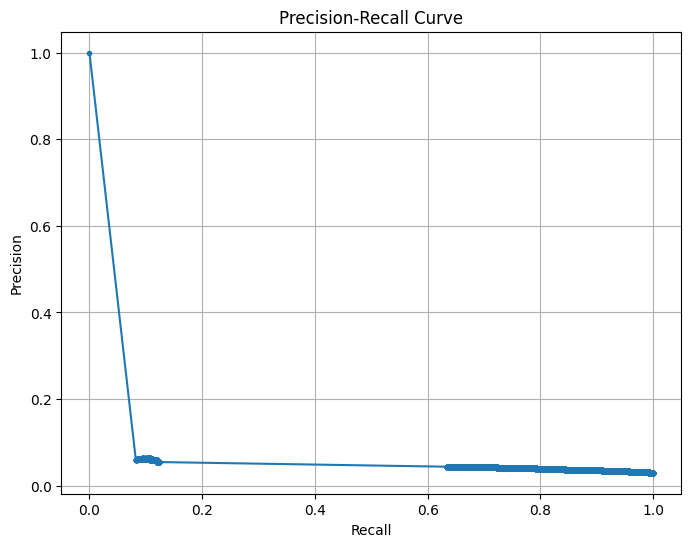

PR AUC: 0.08


In [109]:
# Getting "test" data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_valid)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

# PR curve
# predictions from best model on validation data
predictions = model_list[59].predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc:.2f}')


In [111]:
f1_scores = (2 * precision * recall) / (precision + recall)
print(max(f1_scores))
print(np.argmax(f1_scores))
print(f"Optimal Threshold from Valid data: {thresholds[np.argmax(f1_scores)]}")


0.08152645273200347
20967
Optimal Threshold from Valid data: 0.5035578012466431


1170/1170 [==============================] - 1s 1ms/step


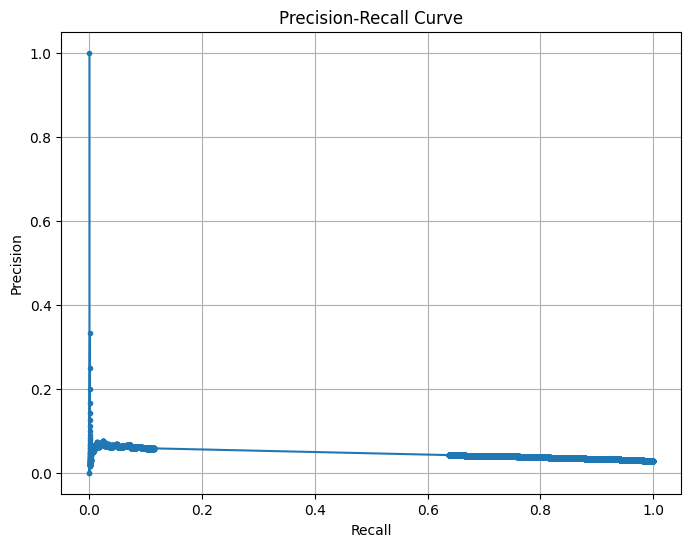

PR AUC: 0.05


In [171]:
# predictions from best model on test data

# getting actual test data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

predictions = model_list[4].predict(X_test)

# PR curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc:.2f}')

In [172]:
len(time_site_pairs_test)

37423

In [167]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

In [182]:
def get_metrics_from_test_df(df):
    y_pred = df['predictions']
    y_actual = df['riskLevelLabel']

    percent_pos_test = sum(y_actual) / len(df)
    f1_ = round(f1_score(y_actual, y_pred), 3)
    roc_auc = round(roc_auc_score(y_actual, y_pred), 3)
    pr_auc = round(average_precision_score(y_actual, y_pred), 3)
    precision = round(precision_score(y_actual, y_pred), 3)
    recall = round(recall_score(y_actual, y_pred), 3)
    accuracy = round(accuracy_score(y_actual, y_pred), 3)
    
    metrics_list = [len(df), percent_pos_test, f1_, roc_auc, pr_auc, precision, recall, accuracy]
    return metrics_list

In [19]:
site_with_region = pd.read_csv('~data/site.csv')
site_with_region

,EUBWID,Site Name in Files,district,lat,long,seasonStartDate,seasonFinishDate,pollutionRiskForecasting,region
0,ukd5300-41300,Ainsdale,Sefton,53.607927,-3.063988,01/05/2022,30/09/2022,True,North West
1,ukd1101-46100,Allonby,Allerdale,54.768036,-3.434625,01/05/2022,30/09/2022,True,North West
2,ukd1101-46000,Allonby_South,Allerdale,54.743960,-3.456454,01/05/2019,30/09/2019,True,North West
3,ukc2101-04250,Amble_Links,Northumberland,55.325652,-1.552401,01/05/2022,30/09/2022,False,North East
4,ukf3102-09400,Anderby,Lincolnshire,53.259774,0.325520,01/05/2022,30/09/2022,False,East Midlands
...,...,...,...,...,...,...,...,...,...
425,uke1200-08900,Withernsea,East Riding of Yorkshire,53.730820,0.036008,01/05/2022,30/09/2022,False,Yorkshire and The Humber
426,ukj1402-11946,Wolvercote_Mill_Stream,Oxford,51.780820,-1.295960,01/05/2022,30/09/2022,False,South East
427,ukk4304-34400,Woolacombe_Village,North Devon,51.171653,-4.209700,01/05/2022,30/09/2022,True,South West
428,ukj2407-15400,Worthing,Worthing,50.807278,-0.384861,01/05/2022,30/09/2022,True,South East


In [22]:
train = pd.merge(time_site_pairs_train, sites_data, on=['time', 'site'])
train = train.merge(site_with_region[['EUBWID', 'region']], how='left', left_on='site', right_on='EUBWID')
train['time'] = pd.to_datetime(train['time'])
train

,time,site,ZSD,CHL,SPM,KD490,BBP,CDM,riskLevelLabel,EUBWID,region
0,2021-05-25,ukk4305-25800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukk4305-25800,South West
1,2022-07-04,ukk4305-25800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukk4305-25800,South West
2,2022-08-08,ukk3105-31450,"[[3.3500542033613443, 3.3500542033613443, 3.35...","[[7.30686214117647, 7.30686214117647, 7.306862...","[[0.9704474882575758, 0.9704474882575758, 0.97...","[[0.276538217815126, 0.276538217815126, 0.2765...","[[0.0036920992657894, 0.0036920992657894, 0.00...","[[0.144712753622807, 0.144712753622807, 0.1447...",0,ukk3105-31450,South West
3,2022-08-27,ukk2206-20800,"[[6.7459197, 6.6718507, 6.566642, 6.4457297, 6...","[[1.4204581, 1.4440619, 1.4789817, 1.5192833, ...","[[3.0617452, 3.2359302, 3.3227324, 3.4029508, ...","[[0.114441626, 0.11552915, 0.11712431, 0.11896...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukk2206-20800,South West
4,2020-06-08,uke1301-09020,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,uke1301-09020,Yorkshire and The Humber
...,...,...,...,...,...,...,...,...,...,...,...
112261,2021-07-19,ukj4210-12660,"[[3.130174548245614, 3.130174548245614, 3.1301...","[[4.270181615789474, 4.270181615789474, 4.2701...","[[5.880774268461538, 5.880774268461538, 5.8807...","[[0.2214226485964912, 0.2214226485964912, 0.22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukj4210-12660,South East
112262,2021-05-10,ukk4200-23200,"[[3.55662035, 3.55662035, 3.55662035, 3.556620...","[[3.5508095, 3.5508095, 3.5508095, 3.5508095, ...","[[2.170633925, 2.170633925, 2.170633925, 2.170...","[[0.19762554, 0.19762554, 0.19762554, 0.197625...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukk4200-23200,South West
112263,2020-08-10,ukk3104-33500,"[[10.020489333333334, 10.020489333333334, 10.0...","[[0.7708462333333334, 0.7708462333333334, 0.77...","[[0.9726023225, 0.9726023225, 0.9726023225, 0....","[[0.0815022166666666, 0.0815022166666666, 0.08...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,ukk3104-33500,South West
112264,2021-09-08,ukk1202-35700,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,ukk1202-35700,South West


In [27]:
def get_percent_pos_train(df):
    y_actual = df['riskLevelLabel']
    return sum(y_actual) / len(df) * 100

In [28]:
# % pos train samples by year
print(f"2020: {get_percent_pos_train(train[train['time'] <= '2020-12-31'])}")
print(f"2021: {get_percent_pos_train(train[(train['time'] <= '2021-12-31') & (train['time'] >= '2021-01-01')])}")
print(f"2022: {get_percent_pos_train(train[train['time'] <= '2020-12-31'])}")

# % pos train samples by month
print(f"May: {get_percent_pos_train(train[train['time'].dt.month==5])}")
print(f"Jun: {get_percent_pos_train(train[train['time'].dt.month==6])}")
print(f"Jul: {get_percent_pos_train(train[train['time'].dt.month==7])}")
print(f"Aug: {get_percent_pos_train(train[train['time'].dt.month==8])}")
print(f"Sep: {get_percent_pos_train(train[train['time'].dt.month==9])}")

# % pos train samples by region
print(f"South West: {get_percent_pos_train(train[train['region'] == 'South West'])}")
print(f"South East: {get_percent_pos_train(train[train['region'] == 'South East'])}")
print(f"East of England: {get_percent_pos_train(train[train['region'] == 'East of England'])}")
print(f"North East: {get_percent_pos_train(train[train['region'] == 'North East'])}")
print(f"North West: {get_percent_pos_train(train[train['region'] == 'North West'])}")
print(f"Yorkshire: {get_percent_pos_train(train[train['region'] == 'Yorkshire and The Humber'])}")
print(f"East Midlands: {get_percent_pos_train(train[train['region'] == 'East Midlands'])}")
print(f"London: {get_percent_pos_train(train[train['region'] == 'London'])}")

2020: 3.291110608459624
2021: 3.0794248986861463
2022: 3.291110608459624
May: 1.5554983260365698
Jun: 2.258435922416084
Jul: 1.8845450291402561
Aug: 3.3907034636679683
Sep: 4.620255987156045
South West: 2.455636207572167
South East: 2.5582128541188127
East of England: 2.1468276787425724
North East: 2.9177139110479726
North West: 5.660134089736977
Yorkshire: 4.209988068859724
East Midlands: 1.9761029411764706
London: 3.2169117647058822


In [186]:
classes = [1 if i > 0.5035578012466431 else 0 for i in predictions]

# Merge predictions onto test dataset
test = pd.merge(time_site_pairs_test, sites_data, on=['time', 'site'])
test['time'] = pd.to_datetime(test['time'])
test['predictions'] = classes

# grouping predictions by year
test_2020 = get_metrics_from_test_df(test[test['time'] <= '2020-12-31'])
test_2021 = get_metrics_from_test_df(test[(test['time'] <= '2021-12-31') & (test['time'] >= '2021-01-01')])
test_2022 = get_metrics_from_test_df(test[test['time'] >= '2022-01-01'])

print(test_2020)
print(test_2021)
print(test_2022)

# grouping predictions by month
test_may = get_metrics_from_test_df(test[test['time'].dt.month==5])
test_jun = get_metrics_from_test_df(test[test['time'].dt.month==6])
test_jul = get_metrics_from_test_df(test[test['time'].dt.month==7])
test_aug = get_metrics_from_test_df(test[test['time'].dt.month==8])
test_sep = get_metrics_from_test_df(test[test['time'].dt.month==9])

print(test_may)
print(test_jun)
print(test_jul)
print(test_aug)
print(test_sep)

# grouping predictions by regions
test = test.merge(site_with_region[['EUBWID', 'region']], how='left', left_on='site', right_on='EUBWID')
test_sw = get_metrics_from_test_df(test[test['region'] == 'South West'])
test_se = get_metrics_from_test_df(test[test['region'] == 'South East'])
test_ee = get_metrics_from_test_df(test[test['region'] == 'East of England'])
test_ne = get_metrics_from_test_df(test[test['region'] == 'North East'])
test_nw = get_metrics_from_test_df(test[test['region'] == 'North West'])
test_yh = get_metrics_from_test_df(test[test['region'] == 'Yorkshire and The Humber'])
test_em = get_metrics_from_test_df(test[test['region'] == 'East Midlands'])

print(test_sw)
print(test_se)
print(test_ee)
print(test_ne)
print(test_nw)
print(test_yh)
print(test_em)

[11766, 0.079, 0.605, 0.039, 0.042, 0.774, 0.447]
[12894, 0.079, 0.602, 0.039, 0.042, 0.771, 0.443]
[12763, 0.059, 0.629, 0.029, 0.031, 0.787, 0.478]
[6430, 0.049, 0.669, 0.024, 0.025, 0.848, 0.496]
[7690, 0.055, 0.608, 0.027, 0.028, 0.78, 0.442]
[7829, 0.054, 0.622, 0.027, 0.028, 0.806, 0.445]
[7683, 0.089, 0.608, 0.044, 0.047, 0.76, 0.467]
[7429, 0.108, 0.588, 0.055, 0.058, 0.752, 0.438]
[17122, 0.067, 0.629, 0.033, 0.035, 0.782, 0.484]
[6421, 0.084, 0.619, 0.041, 0.044, 0.74, 0.506]
[3510, 0.045, 0.575, 0.022, 0.023, 0.738, 0.418]
[2953, 0.089, 0.647, 0.044, 0.047, 0.848, 0.458]
[2557, 0.116, 0.581, 0.061, 0.062, 0.863, 0.328]
[1832, 0.075, 0.516, 0.039, 0.04, 0.629, 0.412]
[363, 0.05, 0.515, 0.026, 0.026, 0.778, 0.264]


In [159]:
test

,time,site,ZSD,CHL,SPM,KD490,BBP,CDM,riskLevelLabel,predictions
0,2022-09-21,ukk3106-32100,"[[4.913196680952381, 4.913196680952381, 4.9131...","[[2.273623676190476, 2.273623676190476, 2.2736...","[[0.4881589017808219, 0.4881589017808219, 0.48...","[[0.1506011823809523, 0.1506011823809523, 0.15...","[[0.00381895475, 0.00381895475, 0.00381895475,...","[[0.06358246325, 0.06358246325, 0.06358246325,...",0,0
1,2020-08-08,ukh1407-10750,"[[3.111512202469136, 3.111512202469136, 3.1115...","[[4.29619640617284, 4.29619640617284, 4.296196...","[[10.269349237931037, 10.269349237931037, 10.2...","[[0.22232296, 0.22232296, 0.22232296, 0.222322...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
2,2020-09-20,ukd4200-42100,"[[3.5333333, 3.5890448, 3.6046667, 3.5832536, ...","[[3.585421, 3.5056612, 3.4843953, 3.5138142, 3...","[[13.234664, 12.486257, 11.963818, 11.449716, ...","[[0.19879897, 0.19607617, 0.19534324, 0.196355...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,0
3,2022-07-06,ukk2206-20900,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
4,2021-08-24,ukk4305-26100,"[[7.55586, 7.613758, 7.6196814, 7.302967, 7.06...","[[1.1989712, 1.1844647, 1.1831877, 1.2617273, ...","[[0.9801996, 0.9878833, 0.98672915, 0.9627455,...","[[0.103905775, 0.103202544, 0.10313862, 0.1069...","[[0.006364123, 0.006630237, 0.0068600005, 0.00...","[[0.059718873, 0.06342808, 0.066719994, 0.0632...",0,0
...,...,...,...,...,...,...,...,...,...,...
37418,2021-09-22,ukj2402-15680,"[[3.5983627, 3.7204835, 3.8346908, 3.8554592, ...","[[3.4994717, 3.3326082, 3.193268, 3.1690927, 3...","[[3.6528094, 3.859371, 4.090318, 4.1943636, 4....","[[0.19582026, 0.19007482, 0.18517214, 0.184313...","[[0.026421161, 0.027476275, 0.029065508, 0.029...","[[0.15839544, 0.15553693, 0.15557131, 0.156752...",0,0
37419,2021-08-14,ukk3104-33500,"[[6.314672, 6.184491423076923, 6.1844914230769...","[[1.5664485, 1.7227391012820514, 1.72273910128...","[[2.1245860052564103, 2.1245860052564103, 2.12...","[[0.121082254, 0.1268671209230769, 0.126867120...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
37420,2022-05-20,ukk4305-25600,"[[7.233569, 6.788397, 6.497776, 6.179102, 5.66...","[[1.2806963, 1.4113798, 1.507687, 1.6207474, 1...","[[0.7209197, 0.8662733, 0.96065444, 1.0638868,...","[[0.10785786, 0.11398184, 0.11837783, 0.123468...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
37421,2022-06-25,ukj3400-18000,"[[4.826235210169491, 4.826235210169491, 4.7515...","[[2.309685054237288, 2.309685054237288, 2.3593...","[[5.076520970270271, 5.076520970270271, 5.0765...","[[0.1522006781355932, 0.1522006781355932, 0.15...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0


In [124]:
test['time'] = pd.to_datetime(test['time'])
test[test['time'].dt.month==5]

,time,site,ZSD,CHL,SPM,KD490,BBP,CDM,riskLevelLabel,predictions
12,2020-05-18,ukh3100-11800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.081272150442478, 11.081272150442478, 11.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
14,2021-05-17,ukj3400-17800,"[[1.7213999670731708, 1.7213999670731708, 1.72...","[[11.465300902439024, 11.465300902439024, 11.4...","[[5.8290533160919535, 5.8290533160919535, 5.82...","[[0.413901141097561, 0.413901141097561, 0.4139...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
15,2022-05-20,ukk3102-28800,"[[8.462011428571428, 8.462011428571428, 8.4620...","[[1.0098425657142858, 1.0098425657142858, 1.00...","[[1.5031724625, 1.5031724625, 1.5031724625, 1....","[[0.0943761257142857, 0.0943761257142857, 0.09...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
16,2020-05-29,ukk3103-29100,"[[2.536445, 2.8695407, 3.3395765, 3.482277, 3....","[[5.9330025, 4.8541126, 3.9149563, 3.6688542, ...","[[0.5655572, 0.56948805, 0.58077556, 0.5880381...","[[0.2714681, 0.23976888, 0.20967583, 0.2015797...","[[0.0034846168, 0.0034846168, 0.0034846168, 0....","[[0.2220552666666666, 0.2220552666666666, 0.22...",0,0
19,2022-05-22,ukd1103-45600,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
...,...,...,...,...,...,...,...,...,...,...
37405,2020-05-15,ukk3106-27700,"[[1.586071975862069, 1.586071975862069, 1.5860...","[[14.029530068965515, 14.029530068965515, 14.0...","[[1.389701678472222, 1.389701678472222, 1.3897...","[[0.4712203374137931, 0.4712203374137931, 0.47...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
37406,2021-05-13,ukk4305-26000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1
37407,2021-05-19,ukk3103-29200,"[[3.6910598, 3.7330277, 3.6836667, 3.6931899, ...","[[3.369864, 3.3179538, 3.387065, 3.3800738, 3....","[[0.8680219, 0.8355887, 0.81544447, 0.79954606...","[[0.19137645, 0.1895548, 0.19192517, 0.1916487...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0
37411,2022-05-07,ukk2305-35000,"[[2.6402642000000003, 2.6402642000000003, 2.64...","[[5.465555887254902, 5.465555887254902, 5.4655...","[[28.75784358490566, 28.75784358490566, 28.757...","[[0.2583801460784313, 0.2583801460784313, 0.25...","[[0.0587452827857142, 0.0587452827857142, 0.05...","[[0.4374420108333333, 0.4374420108333333, 0.43...",0,0


### Getting Results on Test Dataset

#### Hybrid Model

In [ ]:
old_model, old_history = load_model('nn_15x15_7_20_1619')

dataset: L3 1km x 1km 15x15, fillna = mean then 0, num_feature=6, model_type="convolution v3 (lenet)", batch_size=64, epochs=98,
           loss=wbce_custom(40), optimizer=Adam(learning_rate=0.00005), dropout=0.25,
           existing_model = None, metrics=["f1"]. added weight decay l2 regularisation. added batch norm. removed time and site pairs with >8000. 
           early stopping patience = 20. 


In [ ]:
%%time

# Getting X_test and y_test
xy_data = get_train_test_val_nn(sites_data,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

# Get Predictions from neural network model
predictions = old_model.predict(X_test)
classes = [1 if i > 0.5 else 0 for i in predictions]

# Merge predictions onto test dataset
test = pd.merge(time_site_pairs_test, sites_data, on=['time', 'site'])
test['predictions'] = classes

# Add in rest of the data, predict 0


# Get metrics



7566 1889
60/60 [==============================] - 0s 2ms/step
CPU times: user 444 ms, sys: 40 ms, total: 484 ms
Wall time: 453 ms


In [ ]:
len(time_site_pairs_train)

7529

In [ ]:
len(y_test)

1889

In [ ]:
len(X_train) + len(X_val)

7566

#### Loading Saved Model

In [ ]:
%%time

# model_date = "6_26_1757"
# model_name = f"nn_51x51_{model_date}"

model_names = [f"nn_51x51_{i}" for i in ['6_26_2221', '6_26_2310', '6_26_2343']]
old_models = []

for i in range(3):

  old_model, old_history = load_model(model_names[i])
  old_models.append(old_model)

  print(f"Model: {model_names[i]}. Epochs: {len(old_history['loss'])}")

#### Results Dataframe

In [ ]:
%%time
input_data_ = sites_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

# Getting X_test and y_test
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

results = []

for i in range(3):
  result = old_models[i].evaluate(X_test, y_test)
  results.append(result)

In [ ]:
results

In [ ]:
model_names = ['Dropout = 0', 'Dropout = 0.25', 'Dropout = 0.5']

df1 = pd.DataFrame(model_names, columns=['Sub-Model'])
df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
results_df_nn = pd.concat([df1, df2], axis=1)
results_df_nn['Model'] = ['Neural Network']*3
results_df_nn

In [ ]:
results_df_nn.to_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_nn.csv")

In [ ]:
# model_names = []

# for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
#     oversample = "Oversampling" if oversampling__ else "No Oversampling"
#     model_names.append(f'{model_type.capitalize()}, {num_feature} feature, {oversample}')

# df1 = pd.DataFrame(model_names, columns=['Sub-Model'])
# df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
# results_df_nn = pd.concat([df1, df2], axis=1)
# results_df_nn['Model'] = ['Neural Network']*8
# results_df_nn

In [ ]:
# model_names_string = model_names

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

# for j in range(8):
#     ax = ([(k,i) for k in range(4) for i in range(2)])[j]
#     plot_train_val_loss(histories[j], model_names_string[j], ax)

# plt.suptitle('Training Loss vs Validation Loss')
# fig.supxlabel("Epochs")
# fig.supylabel("Loss")
# plt.show()

In [ ]:
# metric='f1'

# fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

# for j in range(8):
#     ax = ([(k,i) for k in range(4) for i in range(2)])[j]
#     plot_train_val_metric(histories[j], model_names_string[j], ax, metric=metric)

# plt.suptitle(f'Training {metric} vs Validation {metric}')
# fig.supxlabel("Epochs")
# fig.supylabel(f"{metric}")
# plt.show()

# Final Results

In [ ]:
results_df_baseline = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/baseline")
results_df_rf = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_rf.csv")
results_df_nn = pd.read_csv("/content/drive/My Drive/CapstoneProject/Results/results_df_nn.csv")

In [ ]:
results_df_baseline.drop('Unnamed: 0', axis=1, inplace=True)
results_df_baseline.rename({'AUC_roc':'AUC'}, axis=1, inplace=True)
results_df_baseline['Sub-Model'] = 'Baseline'
results_df_baseline

In [ ]:
results_df_baseline_final = results_df_baseline[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
results_df_nn_final = results_df_nn[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
results_df_rf_final = results_df_rf[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
# results_df_lr_final = results_df_bc[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]

In [ ]:
pd.concat([results_df_baseline, results_df_nn_final, results_df_rf_final]).set_index(['Model', 'Sub-Model'])

# Window Size Comparison

## BC

In [ ]:
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

In [ ]:
dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11']

performance = {}

for dim in dims:

    cols = [col for col in X_train.columns if dim in col]

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    X_train_scaled_new = scaler.fit_transform(X_train_new)
    X_test_scaled_new = scaler.transform(X_test_new)
    new_lg = lg_model(X_train_scaled_new, y_train)
    y_pred = new_lg.predict(X_test_scaled_new)

    performance[dim] = f1_score(y_test, y_pred)

In [ ]:
f1_scores = [i for i in performance.values()]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Random Forest, Fill NA value with mean')
plt.show()

## RF

In [ ]:
df_train = df_merged_mean.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged_mean.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

In [ ]:
dims = ['_1x1', '3x3', '5x5', '7x7', '9x9', '11x11']

performance = {}

for dim in dims:

    cols = [col for col in X_train.columns if dim in col]

    X_train_new = X_train[cols]
    X_test_new = X_test[cols]

    if dim == '_1x1':
        dim = '1x1'

    performance[dim] = rf_result(X_train_new, y_train, X_test_new, y_test)

In [ ]:
f1_scores = [i['f1'] for i in performance.values()]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Random Forest, Fill NA value with mean')
plt.show()

## NN

In [ ]:
histories = []
results = []

In [ ]:
%%time


# Getting Input Data
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

j = 0
for dim in [1,3,5,7,9,11]:

    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_,
                           time_site_pairs_train,
                           time_site_pairs_test,
                           dim=dim)

    # Get history and result
    _, history, result = fit_nn(xy_data, "convolution")
    histories.append(history)
    results.append(result)

    j += 1
    clear_output(wait=True)
    print(f'Progress: {j}/6')
    print(datetime.now())

In [ ]:
f1_scores = [i[5] for i in results]
plt.plot([1,3,5,7,9,11], f1_scores)
plt.ylabel('F1 Score')
plt.xlabel('Window Size')
plt.title('F1 Score with different window size, for Convolutional Neural Network, 3 feature, No Oversampling')
plt.show()

# Accuracy Comparison

## NN

In [ ]:
%%time
# convolution, 3 features, no oversampling

# Getting Input Data
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]


# Getting xy_data
xy_data = get_train_test_val_nn(input_data_,
                       time_site_pairs_train,
                       time_site_pairs_test)

# Get history and result
model, history, result = fit_nn(xy_data, "convolution")

In [ ]:
test = pd.merge(time_site_pairs_test, input_data_, on=['time', 'site'])
test

In [ ]:
y_test_preds = model.predict(xy_data['X_test'])
test['preds'] = [1 if x >= 0.5 else 0 for x in y_test_preds]

In [ ]:
test['time'] = pd.to_datetime(test['time'])

In [ ]:
test.groupby(pd.Grouper(key='time', freq='M')).apply(lambda x: f1_score(x['riskLevelLabel'], x['preds']))

In [30]:
s2 = pd.read_pickle("~data/nn_51x51.pkl")


In [31]:
s2

,time,site,TUR,SPM,CHL,riskLevelLabel
0,2020-02-29,ukk4304-34200,"[[-0.9811192569131857, -0.9795547499650448, -0...","[[0.524045278902291, 0.5756248475971223, 0.560...","[[0.34057330828591803, 0.370465598289415, 0.34...",1
1,2020-03-12,uke1200-08100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,2020-05-14,ukc1101-06000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,2020-05-14,ukc1101-06100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,2020-05-14,ukc1101-06200,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.401122631769...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.27785837711...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.24223761712...",0
...,...,...,...,...,...,...
52282,2022-09-30,ukj4210-12750,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
52283,2022-09-30,ukj4210-12800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
52284,2022-09-30,ukj4210-12850,"[[1.5549465060235468, 1.5557287594976177, 1.55...","[[1.5127710419438254, 2.94540271916225, 2.7731...","[[1.5251629301217988, 3.2531680809087082, 2.70...",0
52285,2022-09-30,ukj4210-12900,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5525997...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9585223...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8346373...",0


# New sectoin

In [74]:
xy_data = get_train_test_val_nn(sites_data, time_site_pairs_train, time_site_pairs_test, dim=5)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

[[1.4819021  1.7494234  2.7225785  3.542849   3.8239558 ]
 [1.2576548  2.55228326 3.147176   3.379878   3.4176855 ]
 [2.55228326 2.55228326 2.55228326 2.911971   2.917507  ]
 [2.55228326 2.55228326 2.55228326 2.55228326 2.50183   ]
 [2.55228326 2.55228326 2.55228326 2.55228326 2.2846975 ]]


In [60]:
input_data, train_labels, test_labels = sites_data, time_site_pairs_train, time_site_pairs_test

train = pd.merge(train_labels, input_data, on=['time', 'site'])
test = pd.merge(test_labels, input_data, on=['time', 'site'])

In [61]:
train

,time,site,ZSD,CHL,SPM,KD490,BBP,CDM,riskLevelLabel
0,2021-05-25,ukk4305-25800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,2022-07-04,ukk4305-25800,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,2022-08-08,ukk3105-31450,"[[3.3500542033613443, 3.3500542033613443, 3.35...","[[7.30686214117647, 7.30686214117647, 7.306862...","[[0.9704474882575758, 0.9704474882575758, 0.97...","[[0.276538217815126, 0.276538217815126, 0.2765...","[[0.0036920992657894, 0.0036920992657894, 0.00...","[[0.144712753622807, 0.144712753622807, 0.1447...",0
3,2022-08-27,ukk2206-20800,"[[6.7459197, 6.6718507, 6.566642, 6.4457297, 6...","[[1.4204581, 1.4440619, 1.4789817, 1.5192833, ...","[[3.0617452, 3.2359302, 3.3227324, 3.4029508, ...","[[0.114441626, 0.11552915, 0.11712431, 0.11896...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,2020-06-08,uke1301-09020,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...,...,...,...,...,...,...,...
112261,2021-07-19,ukj4210-12660,"[[3.130174548245614, 3.130174548245614, 3.1301...","[[4.270181615789474, 4.270181615789474, 4.2701...","[[5.880774268461538, 5.880774268461538, 5.8807...","[[0.2214226485964912, 0.2214226485964912, 0.22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
112262,2021-05-10,ukk4200-23200,"[[3.55662035, 3.55662035, 3.55662035, 3.556620...","[[3.5508095, 3.5508095, 3.5508095, 3.5508095, ...","[[2.170633925, 2.170633925, 2.170633925, 2.170...","[[0.19762554, 0.19762554, 0.19762554, 0.197625...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
112263,2020-08-10,ukk3104-33500,"[[10.020489333333334, 10.020489333333334, 10.0...","[[0.7708462333333334, 0.7708462333333334, 0.77...","[[0.9726023225, 0.9726023225, 0.9726023225, 0....","[[0.0815022166666666, 0.0815022166666666, 0.08...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
112264,2021-09-08,ukk1202-35700,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [44]:
train['SPM'][3]

array([[3.0617452 , 3.2359302 , 3.3227324 , 3.4029508 , 3.1574073 ,
        2.8736236 , 2.4701855 , 1.1479132 , 2.55228326, 2.55228326,
        2.9266276 , 3.1363342 , 3.3378937 , 3.6139536 , 3.8339348 ],
       [3.2429392 , 3.2713253 , 3.239215  , 3.1935227 , 2.8879313 ,
        2.5589433 , 2.2047923 , 1.5037377 , 2.55228326, 2.55228326,
        2.55228326, 2.9470282 , 2.9978037 , 3.0879948 , 3.4209468 ],
       [3.381822  , 3.2321131 , 3.1171763 , 2.9970057 , 2.4799316 ,
        2.1646128 , 1.8915683 , 1.70582   , 1.7058163 , 2.55228326,
        2.55228326, 2.55228326, 2.463403  , 2.668908  , 3.14289   ],
       [3.3067923 , 3.108512  , 2.845334  , 2.5451927 , 1.9333152 ,
        1.7099026 , 1.5353427 , 1.542206  , 1.5422037 , 2.55228326,
        2.55228326, 2.55228326, 2.2490697 , 2.6466756 , 3.033093  ],
       [3.0228162 , 2.6908624 , 2.3387325 , 1.9486151 , 1.5884695 ,
        1.4770083 , 1.4317526 , 1.7419043 , 2.6052518 , 2.55228326,
        2.55228326, 2.7998922 , 2.7958941 , 

In [71]:
dim = 5

w = int((dim-1)/2)

indices = np.array(range(1,226)).reshape(15,15)[7-w:8+w, 7-w:8+w].flatten()
indices = [i-1 for i in indices]

In [72]:
indices

[80,
 81,
 82,
 83,
 84,
 95,
 96,
 97,
 98,
 99,
 110,
 111,
 112,
 113,
 114,
 125,
 126,
 127,
 128,
 129,
 140,
 141,
 142,
 143,
 144]

In [62]:
dim = 5

w = int((dim-1)/2)

train_new = pd.DataFrame()
test_new = pd.DataFrame()

def get_windowed_data(row):
    indices = np.array(range(1,226)).reshape(15,15)[7-w:8+w, 7-w:8+w].flatten()
    indices = [i-1 for i in indices]
    values = row.flatten()[[indices]].reshape(dim,dim)
    return values

if dim != 15:
    for feature in ['ZSD','CHL','SPM','KD490','BBP','CDM']:
        train[f'{feature}'] = train[f'{feature}'].apply(get_windowed_data)
        test[f'{feature}'] = test[f'{feature}'].apply(get_windowed_data)

done
done
done
done
done
done
done
done
done
done
done
done


In [50]:
row = trial

indices = np.array(range(1,226)).reshape(15,15)[7-w:8+w, 7-w:8+w].flatten()
indices = [i-1 for i in indices]
values = row.flatten()[[indices]].reshape(dim,dim)

In [56]:
print(w)
train['SPM'].apply(get_windowed_data)

6


0         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2         [[0.9704474882575758, 0.9704474882575758, 0.97...
3         [[3.2713253, 3.239215, 3.1935227, 2.8879313, 2...
4         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                ...                        
112261    [[5.880774268461538, 5.880774268461538, 5.8807...
112262    [[2.170633925, 2.170633925, 2.170633925, 2.170...
112263    [[0.9726023225, 0.9726023225, 0.9726023225, 0....
112264    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
112265    [[0.37191105, 0.37656707, 0.3811384, 0.3862034...
Name: SPM, Length: 112266, dtype: object

In [99]:
loss = wbce_custom(3)
metric = f1
best_model_f0 = tf.keras.models.load_model('cnn_f0_best.keras', custom_objects={loss.__name__: loss, metric.__name__: metric})

In [100]:
input_data_ = sites_data

# Getting "test" data
xy_data = get_train_test_val_nn(input_data_,
                      time_site_pairs_train,
                      time_site_pairs_test)

X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()

predictions_f0 = best_model_f0.predict(X_test)
classes_f0 = [1 if i > 0.5 else 0 for i in predictions_f0]

[[3.0617452  3.2359302  3.3227324  3.4029508  3.1574073  2.8736236
  2.4701855  1.1479132  2.55228326 2.55228326 2.9266276  3.1363342
  3.3378937  3.6139536  3.8339348 ]
 [3.2429392  3.2713253  3.239215   3.1935227  2.8879313  2.5589433
  2.2047923  1.5037377  2.55228326 2.55228326 2.55228326 2.9470282
  2.9978037  3.0879948  3.4209468 ]
 [3.381822   3.2321131  3.1171763  2.9970057  2.4799316  2.1646128
  1.8915683  1.70582    1.7058163  2.55228326 2.55228326 2.55228326
  2.463403   2.668908   3.14289   ]
 [3.3067923  3.108512   2.845334   2.5451927  1.9333152  1.7099026
  1.5353427  1.542206   1.5422037  2.55228326 2.55228326 2.55228326
  2.2490697  2.6466756  3.033093  ]
 [3.0228162  2.6908624  2.3387325  1.9486151  1.5884695  1.4770083
  1.4317526  1.7419043  2.6052518  2.55228326 2.55228326 2.7998922
  2.7958941  2.878689   3.040211  ]
 [2.6860619  2.2902606  2.0202277  1.7454636  1.4193717  1.4819021
  1.7494234  2.7225785  3.542849   3.8239558  3.493297   3.3240626
  3.2258062  3

In [137]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, average_precision_score, f1_score

metrics = []

for model in [best_model_f0]:

    pred_prob = model.predict(X_test)
    pred_class = [1 if i>0.5 else 0 for i in pred_prob]
    
    f1_ = round(f1_score(y_test, pred_class), 5)
    precision = round(precision_score(y_test, pred_class), 3)
    recall = round(recall_score(y_test, pred_class), 3)
    pr_auc = round(average_precision_score(y_test, pred_prob), 3)
    roc_auc = round(roc_auc_score(y_test, pred_prob), 3)   
    accuracy = round(accuracy_score(y_test, pred_class), 3)

    metrics.append([f1_,precision,recall,pr_auc,roc_auc,accuracy])

pd.DataFrame(metrics, columns=['f1','precision','recall','pr_auc','roc_auc','accuracy'])

1170/1170 [==============================] - 1s 808us/step


,f1,precision,recall,pr_auc,roc_auc,accuracy
0,0.07418,0.039,0.672,0.039,0.623,0.537


1170/1170 [==============================] - 1s 1ms/step


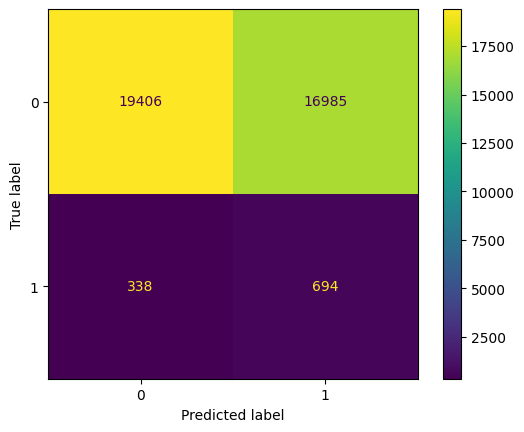

In [144]:
model = best_model_f0
pred_prob = model.predict(X_test)
pred_class = [1 if i>0.5 else 0 for i in pred_prob]

confusion_matrix_plot(y_test, pred_class)

In [139]:
def plot_roc_pr_graphs(model, predictions):
    # predictions from best model on validation data
    # predictions = model.predict(X_test)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    # PR curve and AP
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)
    average_precision = average_precision_score(y_test, predictions)

    # plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.',label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
    plt.grid(True)
    plt.legend(loc="lower right", fontsize=15)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label='PR curve (AP = %0.4f)' % average_precision)
    plt.axhline(y=baseline_val, color="gray", linestyle='--', label='Baseline')
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.title('Precision-Recall (PR) Curve', fontsize=15)
    plt.grid(True)
    plt.legend(loc="upper right", fontsize=15)

    plt.tight_layout()
    plt.show()

In [141]:
train = pd.merge(time_site_pairs_train, sites_data, on=['time', 'site'])
baseline_val = sum(train['riskLevelLabel'])/len(train)
baseline_val

0.027960379812231664

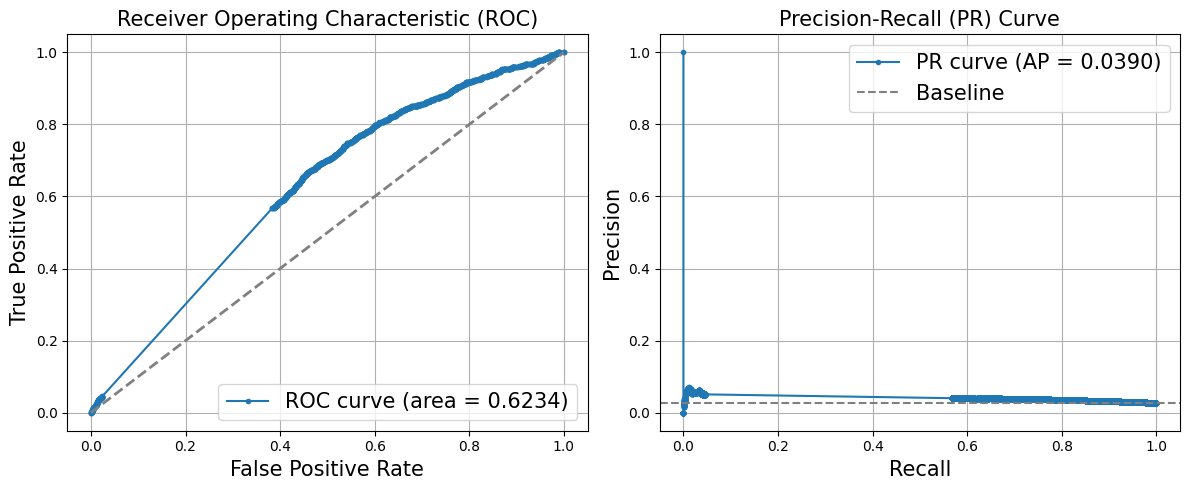

In [140]:
plot_roc_pr_graphs(best_model_f0, predictions_f0)